In [1]:


import tensorflow as tf

from tensorflow.keras import datasets, layers, models, regularizers, optimizers
from tensorflow.keras.layers import BatchNormalization
import matplotlib.pyplot as plt
import os

import kagglehub

# Download latest version
path = kagglehub.dataset_download("abenjelloun/breast-mri-tumor-classification-dataset")

print("Path to dataset files:", path)

dataset_dir = path  # Corrected path to point directly to the downloaded directory
print("Dataset directory:", dataset_dir)
# List the contents of the dataset_dir to inspect the structure and find the correct subdirectory
print("Contents of dataset directory:")
for item in os.listdir(dataset_dir):
    print(item)
    # Check inside subdirectories for 'Training' and 'Validation'
    item_path = os.path.join(dataset_dir, item)
    if os.path.isdir(item_path):
        print(f"Contents of {item}:")
        try:
            for sub_item in os.listdir(item_path):
                print(f"- {sub_item}")
        except Exception as e:
            print(f"Could not list contents of {item_path}: {e}")

100%|██████████| 411M/411M [00:19<00:00, 21.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/abenjelloun/breast-mri-tumor-classification-dataset/versions/1
Dataset directory: /root/.cache/kagglehub/datasets/abenjelloun/breast-mri-tumor-classification-dataset/versions/1
Contents of dataset directory:
breast_mri_dataset_original_shape
Contents of breast_mri_dataset_original_shape:
- val
- test
- train
breast_mri_dataset
Contents of breast_mri_dataset:
- val
- test
- train


In [2]:
train_images = tf.keras.utils.image_dataset_from_directory(
    os.path.join(dataset_dir, 'breast_mri_dataset', 'train'), # Corrected path based on actual directory structure
    validation_split=0.2,
    shuffle=True,
    seed = 123,
    subset="training",
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=90,
    image_size=(224,224),
)

test_images = tf.keras.utils.image_dataset_from_directory(
    os.path.join(dataset_dir, 'breast_mri_dataset', 'val'), # Corrected path based on actual directory structure
    # validation_split=1.0,
    seed = None,
    shuffle = False,
    # subset="validation",
    labels="inferred",
    label_mode="int",
    image_size=(224,224),
    color_mode="rgb",

)

# Function to convert RGB images to grayscale
def rgb_to_grayscale(image, label):
    image = tf.image.rgb_to_grayscale(image)
    return image, label

# Apply the conversion to grayscale
train_images = train_images.map(rgb_to_grayscale)
test_images = test_images.map(rgb_to_grayscale)

# Normalize pixel values to be between 0 and 1
train_images = train_images.map(lambda image, label: (image / 255.0, label))
test_images = test_images.map(lambda image, label: (image / 255.0, label))

Found 16826 files belonging to 2 classes.
Using 13461 files for training.
Found 3594 files belonging to 2 classes.


In [3]:
model = models.Sequential()

# Change the input_shape to (224, 224, 1) for grayscale images
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())


model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.4)) # Add dropout layer
# Change the output layer for binary classification (2 classes)
model.add(layers.Dense(1, activation='sigmoid',# Use sigmoid for binary classification
    kernel_regularizer=regularizers.L1L2(l1=1e-3, l2=1e-4),
    bias_regularizer=regularizers.L2(1e-3),
    activity_regularizer=regularizers.L2(1e-3)))
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 173056)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    11,075,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,132,097 (42.47 MB)

 Trainable params: 11,131,777 (42.46 MB)

 Non-trainable params: 320 (1.25 KB)

In [4]:
# import matplotlib.pyplot as plt
# import tensorflow as tf

# plt.figure(figsize=(10, 10))
# for images, labels in train_images.take(1): # Take one batch to display
#     for i in range(min(25, images.shape[0])): # Iterate through images in the batch
#         plt.subplot(5, 5, i + 1)
#         plt.xticks([])
#         plt.yticks([])
#         plt.grid(False)
#         # Squeeze the image to remove the channel dimension for grayscale images
#         plt.imshow((images[i]), cmap='gray', aspect='auto') # Added aspect='auto'
#         plt.axis('off') # Added to turn off axis
#         # You might want to add a title based on the label if you have class names
#         # plt.title(class_names[labels[i]])
# plt.show()

Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 46s 220ms/step - accuracy: 0.7305 - loss: 0.6577 - val_accuracy: 0.5000 - val_loss: 0.7623
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 23s 155ms/step - accuracy: 0.9553 - loss: 0.1963 - val_accuracy: 0.5136 - val_loss: 0.6541
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 26s 174ms/step - accuracy: 0.9792 - loss: 0.1299 - val_accuracy: 0.6055 - val_loss: 0.5514
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 24s 158ms/step - accuracy: 0.9880 - loss: 0.1073 - val_accuracy: 0.9521 - val_loss: 0.1705
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 24s 159ms/step - accuracy: 0.9924 - loss: 0.0928 - val_accuracy: 0.9900 - val_loss: 0.0650
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 24s 162ms/step - accuracy: 0.9950 - loss: 0.0852 - val_accuracy: 0.9925 - val_loss: 0.0540
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 159ms/step - accuracy: 0.9955 - loss: 0.0791 - val_accuracy: 0.9936 - val_loss: 0.0494
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 24s 160ms/step - accuracy: 0.9972 - loss: 0

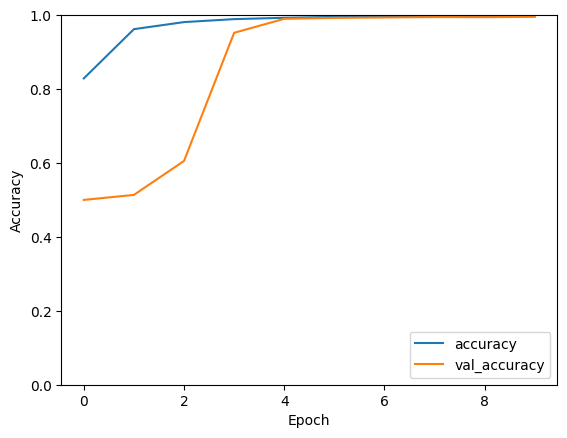

In [5]:

tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=1,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0
)
model.compile(optimizer= 'Adagrad',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = model.fit(train_images, validation_data=test_images, epochs=10)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images, verbose=2)
print(test_acc)